In [1]:
import os

from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from deepcell_tracking.metrics import calculate_summary_stats

sns.set_style("whitegrid")

In [17]:
baxter_path = '../benchmarking/Baxter/benchmarks.csv'
embedtrack_path = '../benchmarking/EmbedTrack/benchmarks.csv'
deepcell_path = '../benchmarking/DeepCell/benchmarks.csv'
tracx_path = '../benchmarking/TracX/benchmarks.csv'
celltrackergnn_path = '../benchmarking/CellTrackerGNN/benchmarks.csv'

sum_columns = [
    'correct_division', 'mismatch_division',
    'false_positive_division', 'false_negative_division', 'total_divisions',
    'aa_tp', 'aa_total', 'te_tp', 'te_total']
mean_columns = ['DET', 'SEG', 'TRA']

stats_columns = ['Division F1', 'Mitotic branching correctness', 'Association Accuracy', 'Target Effectiveness', 'TRA']
labels = {
    'Division F1': 'Division\nF1',
    'Mitotic branching correctness': 'MBC',
    'Association Accuracy': 'AA',
    'Target Effectiveness': 'TE'
}

# Data Prep

In [3]:
paths = [deepcell_path, baxter_path, embedtrack_path, tracx_path, celltrackergnn_path]
dfs = []
for path in paths:
    sdf = pd.read_csv(path, index_col=0)
    
    # Rollup data for each model version
    sdf_a = sdf[['model'] + sum_columns].groupby('model').sum().reset_index()
    sdf_b = sdf[['model'] + mean_columns].groupby('model').mean().reset_index()
    sdf = sdf_a.merge(sdf_b, on='model')
    dfs.append(sdf)
    
df = pd.concat(dfs).set_index('model')

In [4]:
def calculate_stats(row):
    cols = ['correct_division', 'false_positive_division', 'false_negative_division', 'total_divisions',
            'aa_tp', 'aa_total', 'te_tp', 'te_total']
    d = row[cols].to_dict()
    return pd.Series(calculate_summary_stats(**d))

df = df.join(df.apply(calculate_stats, axis=1))

In [5]:
df

,correct_division,mismatch_division,false_positive_division,false_negative_division,total_divisions,aa_tp,aa_total,te_tp,te_total,DET,SEG,TRA,Division Recall,Division Precision,Division F1,Mitotic branching correctness,Fraction missed divisions,Association Accuracy,Target Effectiveness
model,,,,,,,,,,,,,,,,,,,
Deepcell - Deepcell,151.0,11.0,10.0,16.0,178.0,47007.0,48390.0,48364.0,49775.0,0.990764,0.923929,0.989835,0.90,0.94,0.92,0.85,0.09,0.97,0.97
Deepcell - GT,169.0,1.0,3.0,8.0,178.0,47908.0,48390.0,49293.0,49775.0,1.000000,1.000000,0.999636,0.95,0.98,0.97,0.94,0.04,0.99,0.99
Baxter - Deepcell,86.0,7.0,30.0,85.0,178.0,47610.0,48390.0,48911.0,49775.0,0.988279,0.919609,0.987211,0.50,0.74,0.60,0.43,0.48,0.98,0.98
Baxter - GT,104.0,6.0,13.0,68.0,178.0,48171.0,48390.0,49493.0,49775.0,0.997080,0.996160,0.996567,0.60,0.89,0.72,0.56,0.38,1.00,0.99
EmbedTrack - Fluo-N2DH-GOWT1,0.0,0.0,15.0,108.0,108.0,4850.0,29504.0,5192.0,30321.0,0.238841,0.179327,0.231180,0.00,0.00,0.00,0.00,1.00,0.16,0.17
EmbedTrack - Fluo-N2DH-SIM+,0.0,7.0,1500.0,171.0,178.0,25167.0,48390.0,26326.0,49775.0,0.826697,0.397969,0.779315,0.00,0.00,0.00,0.00,0.96,0.52,0.53
EmbedTrack - Fluo-N2DL-HeLa,108.0,10.0,533.0,60.0,178.0,39605.0,48390.0,40739.0,49775.0,0.816220,0.641730,0.815163,0.64,0.17,0.27,0.15,0.34,0.82,0.82
TracX - Deepcell,42.0,45.0,121.0,91.0,178.0,45986.0,48390.0,47343.0,49775.0,0.990764,0.923929,0.989102,0.32,0.26,0.28,0.17,0.51,0.95,0.95
TracX - GT,42.0,56.0,36.0,80.0,178.0,47293.0,48390.0,48678.0,49775.0,1.000000,1.000000,0.998686,0.34,0.54,0.42,0.27,0.45,0.98,0.98


In [7]:
# Restrict models with multiple candidates to their top performing candidate
top_embedtrack = 'Fluo-N2DL-HeLa'
top_celltrackergnn = 'Fluo-N2DL-HeLa'

drop_models = []
for m in df.index:
    if 'EmbedTrack' in m and top_embedtrack not in m:
        drop_models.append(m)
    if 'CellTrackerGNN' in m and top_celltrackergnn not in m:
        drop_models.append(m)
        
df = df.drop(index=drop_models).rename({
    f'CellTrackerGNN {top_celltrackergnn} - GT': 'CellTrackerGNN - GT',
    f'CellTrackerGNN {top_celltrackergnn} - Pred': 'CellTrackerGNN - CellTrackerGNN',
    f'EmbedTrack - {top_embedtrack}': 'EmbedTrack - EmbedTrack'
})

In [8]:
# Create new columns for tracking and segmentation models 
df = df.reset_index()
df[['tracking', 'segmentation']] = df['model'].str.split(' - ', expand=True)

# Add empty missing value for GT EmbedTrack benchmarking
df = df.append({'model': 'EmbedTrack - GT', 'tracking': 'EmbedTrack', 'segmentation': 'GT'}, ignore_index=True).fillna(0.000001)

/tmp/ipykernel_835/2648185577.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'model': 'EmbedTrack - GT', 'tracking': 'EmbedTrack', 'segmentation': 'GT'}, ignore_index=True).fillna(0.000001)


In [9]:
df

,model,correct_division,mismatch_division,false_positive_division,false_negative_division,total_divisions,aa_tp,aa_total,te_tp,te_total,...,TRA,Division Recall,Division Precision,Division F1,Mitotic branching correctness,Fraction missed divisions,Association Accuracy,Target Effectiveness,tracking,segmentation
0,Deepcell - Deepcell,151.000000,11.000000,10.000000,16.000000,178.000000,47007.000000,48390.000000,48364.000000,49775.000000,...,0.989835,0.900000,0.940000,0.920000,0.850000,0.090000,0.970000,0.970000,Deepcell,Deepcell
1,Deepcell - GT,169.000000,1.000000,3.000000,8.000000,178.000000,47908.000000,48390.000000,49293.000000,49775.000000,...,0.999636,0.950000,0.980000,0.970000,0.940000,0.040000,0.990000,0.990000,Deepcell,GT
2,Baxter - Deepcell,86.000000,7.000000,30.000000,85.000000,178.000000,47610.000000,48390.000000,48911.000000,49775.000000,...,0.987211,0.500000,0.740000,0.600000,0.430000,0.480000,0.980000,0.980000,Baxter,Deepcell
3,Baxter - GT,104.000000,6.000000,13.000000,68.000000,178.000000,48171.000000,48390.000000,49493.000000,49775.000000,...,0.996567,0.600000,0.890000,0.720000,0.560000,0.380000,1.000000,0.990000,Baxter,GT
4,EmbedTrack - EmbedTrack,108.000000,10.000000,533.000000,60.000000,178.000000,39605.000000,48390.000000,40739.000000,49775.000000,...,0.815163,0.640000,0.170000,0.270000,0.150000,0.340000,0.820000,0.820000,EmbedTrack,EmbedTrack
5,TracX - Deepcell,42.000000,45.000000,121.000000,91.000000,178.000000,45986.000000,48390.000000,47343.000000,49775.000000,...,0.989102,0.320000,0.260000,0.280000,0.170000,0.510000,0.950000,0.950000,TracX,Deepcell
6,TracX - GT,42.000000,56.000000,36.000000,80.000000,178.000000,47293.000000,48390.000000,48678.000000,49775.000000,...,0.998686,0.340000,0.540000,0.420000,0.270000,0.450000,0.980000,0.980000,TracX,GT
7,CellTrackerGNN - GT,97.000000,29.000000,847.000000,52.000000,178.000000,44777.000000,48390.000000,46157.000000,49775.000000,...,0.996419,0.650000,0.100000,0.180000,0.100000,0.290000,0.930000,0.930000,CellTrackerGNN,GT
8,CellTrackerGNN - CellTrackerGNN,56.000000,47.000000,1176.000000,75.000000,178.000000,36567.000000,48390.000000,37593.000000,49775.000000,...,0.811647,0.430000,0.050000,0.080000,0.040000,0.420000,0.760000,0.760000,CellTrackerGNN,CellTrackerGNN
9,EmbedTrack - GT,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,EmbedTrack,GT


In [18]:
plot_df = df.melt(
    id_vars=['model', 'tracking', 'segmentation'],
    value_vars=stats_columns,
    var_name='metric'
    )

# Merge to put one tracking model per row
plot_df = plot_df[plot_df['segmentation'] == 'GT'].merge(plot_df[plot_df['segmentation'] != 'GT'],
                                                         on=['tracking', 'metric'],
                                                         suffixes=['_gt', '_pred'])
plot_df = plot_df.replace(labels)

# Plotting

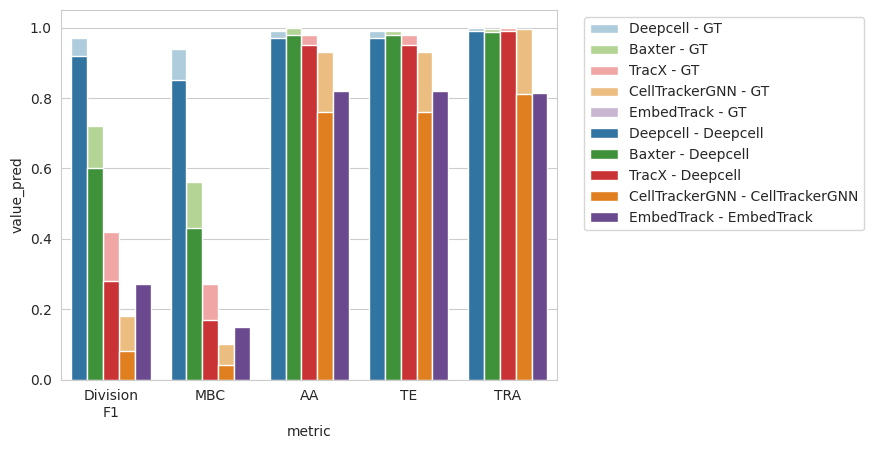

In [26]:
fig, ax = plt.subplots()

sns.barplot(
    data=plot_df,
    x='metric',
    y='value_gt',
    hue='model_gt',
    palette=sns.color_palette("Paired")[::2]
) 
sns.barplot(
    data=plot_df,
    x='metric',
    y='value_pred',
    hue='model_pred',
    palette=sns.color_palette("Paired")[1::2]
)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
fig.savefig('benchmarking.pdf')

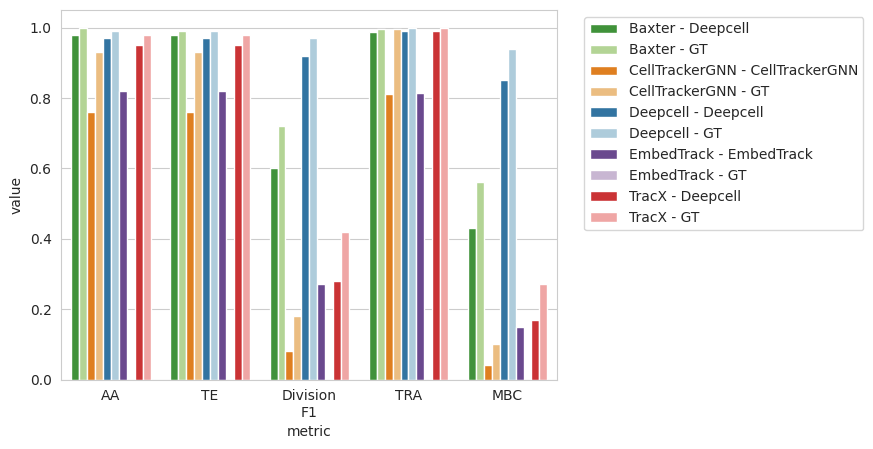

In [24]:
gt_colors = {
    'Deepcell - GT': paired_cb[0], 
    'Baxter - GT': paired_cb[2],
    'TracX - GT': paired_cb[4],
    'CellTrackerGNN - GT': paired_cb[6],
    'EmbedTrack - GT': paired_cb[8]
}
pred_colors = {
    'Deepcell - Deepcell': paired_cb[1],
    'Baxter - Deepcell': paired_cb[3],
    'TracX - Deepcell': paired_cb[5],
    'CellTrackerGNN - CellTrackerGNN': paired_cb[7],
    'EmbedTrack - EmbedTrack': paired_cb[9],
}
stats = df.melt(
    id_vars=['model', 'tracking', 'segmentation'],
    value_vars=stats_columns,
    var_name='metric'
    ).sort_values('model'
    ).replace(labels)

fig, ax = plt.subplots()

sns.barplot(
    data=stats,
    x='metric',
    y='value',
    hue='model',
    palette={**gt_colors, **pred_colors}
) 

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")